## Fragment recruitment using bwa and bbmap
* editing rcov.py to output more than just labelled contigs
* all this is run on charlie
* bbmap run through mp_recruit.py script.

```
mg1=./Test_FragRecruitment/Sakinaw/Hallam_metagenomes/2079.6.1746.fastq.gz 
mg2=./Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454.fastq.gz
gnms=./Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/
outdir=./fragdev/20160525/
```
this run was still running at the end of the day in a screen session
```
python ~/scripts/mp_recruit.py jrmr --fq1 ../Test_FragRecruitment/Sakinaw/Hallam_metagenomes/2079.6.1746.fastq.gz \
--outdir 20160525 --refdir ../Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/ \
--join --len_filter 150 &> 0525_jrmr2.log
```
this run finished:
```
python ~/scripts/mp_recruit.py jrmr --fq1 ../Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454.fastq.gz \
--outdir 20160525 --refdir ../Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/ \
--len_filter 150 &> 0525_jrmr3.log
```

re-run with max len set, and fasta file input:

```
mg2lenfilt=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454_gt150.fastq.gz
mg2fasta=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454TrimmedReads.fasta

python ~/scripts/mp_recruit.py jrmr --fq1 $mg2fasta --outdir ./20160525 \
--refdir ../Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/ \
--max_len 600 &> 0525_jrmr4.log
```

re-run illumina mg with changes to script:
```
mg1joined=/mnt/stepanauskas_nfs/julia/fragdev/20160525/2079.6.1746_gt150.fastq.extendedFrags_gt150.fastq.gz
outdir=/mnt/stepanauskas_nfs/julia/fragdev/20160525/
refdir=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/

python ~/scripts/mp_recruit.py jrmr --fq1 $mg1joined --outdir $outdir \
--refdir $refdir &> 0527_jrmr.log
```

more variables:
```
log=0525_rcov1.log
outdir=./fragdev/20160525/
mg2lenfilt=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454_gt150.fastq.gz
```

bwa alignment:

```
parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg2lenfilt --reference {1} --outdir $outdir :::: firstlist.txt
```

And then this for the illumina library bwa:

```
mg1curated=/mnt/stepanauskas_nfs/julia/fragdev/20160525/2079.6.1746_gt150.fastq.extendedFrags_gt150.fastq.gz
log=0526_rcov2.log
parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg1curated --reference {1} --outdir $outdir :::: firstlist.txt
```

And again with even newer changes:
```

mgs=fragdev/20160525/2079.6.1746_gt150.fastq.extendedFrags_gt150.fastq.gz Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454_gt150.fastq.gz
log=0527_ncov.log
outdir=fragdev/20160525

parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq {1} --reference {2} --outdir $outdir :::: mgs.txt :::: firstlist.txt
```

Now that these are all done and the scripts have been hashed out (a bit), a look at prelminary results:

In [1]:
import pandas as pd
import gzip
import os.path as op
from collections import defaultdict
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from pysam import FastxFile

def readfx(fastx):
    fx = ""
    try:
        fx = FastxFile(fastx)
        for f in fx:
            yield f.name, f.sequence, f.quality
    finally:
        if fx:
            fx.close()

In [2]:
gzopen = lambda x: gzip.open(x) if x.endswith(".gz") else open(x)

In [3]:
def plot_read_size(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    for name, seq, qual in readfx(fastq):
        readsizes[len(seq)] += 1
        readcount += 1
    hist = pd.DataFrame.from_dict(readsizes, orient='index')
    hist['length']=hist.index
    hist['read_count']=hist[0]
    fig = plt.plot(hist['length'], hist['read_count'], color='b')
    plt.ylabel('# reads')
    plt.xlabel('read length')
    filename = op.dirname(fastq)+"_".join(op.basename(fastq).split(".")[:-1])+".png"
    name = "_".join(op.basename(fastq).split(".")[:-1])+".png"
    plt.title('%s: %s total reads' % (name, readcount))
    return plt, readcount

In [4]:
count=0
fastq = "../data/big_data/GZFH_454_gt150.fastq.gz"
for name, seq, qual in readfx(fastq):
    count += 1

In [5]:
print(count)

554957


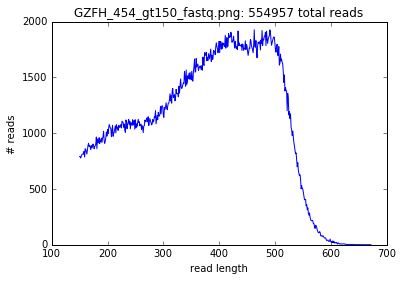

In [6]:
plt, readcount = plot_read_size("../data/big_data/GZFH_454_gt150.fastq.gz")

In [7]:
print(readcount)

554957


## bbmap and bwa results:

In [8]:
import glob
import os

In [9]:
bbresults = glob.glob("../data/i454comp/*recruit_info.txt")

In [10]:
for i, r in enumerate(bbresults):
    print(r)
    print(os.path.basename(r).split("_")[0])
    din = pd.read_csv(r, sep="\t")
    din = din.rename(columns={"Unnamed: 0":"sag"})
#    din['STAT'] = din['stat']
    #din = din.set_index(din.stat)

    tin = din.transpose()
    tin.columns = tin.iloc[0]
    tin = tin.iloc[1:]
    tin['metagenome'] = os.path.basename(r).split("_")[0] 
    sags = list(tin.index)
    tin['sag'] = sags
    tin['method'] = 'bbmap'
    if i == 0:
        newdf = pd.DataFrame()
    
    newdf = pd.concat([tin, newdf])

#newdf = newdf.convert_objects(convert_numeric=True)

../data/i454comp/2079_6_1746_gt150_fastq_extendedFrags_gt150_fastq_recruit_info.txt
2079
../data/i454comp/GZFH_454TrimmedReads_recruit_info.txt
GZFH


In [11]:
newdf

sag,perfect_best_site,unambiguous,Percent_scaffolds_with_any_coverage,Percent_of_reference_bases_covered,Average_coverage,Reads_Used,metagenome,sag,method
AAA255A6_96912,1508,9643,100,85.68,2.27,676245,GZFH,AAA255A6_96912,bbmap
AAA255B16_97682,2919,17830,100,95.51,5.4,676245,GZFH,AAA255B16_97682,bbmap
AAA255C20_98068,3509,22088,100,95.9,5.24,676245,GZFH,AAA255C20_98068,bbmap
AAA255A6_96912,937248,1.36612e+06,100,99.39,234.01,7.12875e+07,2079,AAA255A6_96912,bbmap
AAA255B16_97682,1.76714e+06,2.64831e+06,100,99.75,592.72,7.12875e+07,2079,AAA255B16_97682,bbmap
AAA255C20_98068,2.20016e+06,3.29452e+06,100,99.73,577.95,7.12875e+07,2079,AAA255C20_98068,bbmap


In [12]:
def get_recruit_info(gcov):
    countfile = gcov.replace("genomecoverage", "aln_count")
    with open(countfile) as infile:
        recruit_count = infile.read().split()[1].strip()
        
    metagenome = op.basename(gcov).split("_vs_")[0].split("_")[0]
    coverage = pd.read_csv(gcov, sep="\t", header=None)
    mean_per_contig = coverage.groupby([0])[2].mean() #.to_dict()
    sum_per_contig = coverage.groupby([0])[2].sum() #.to_dict()
    contig_size = coverage.groupby([0])[1].max()+1
    mean_sag_coverage = mean_per_contig.mean()
    totalbp = contig_size.sum()
    uncovered_bp = sum(coverage[2]==0)
    pct_covered = (totalbp - uncovered_bp)/totalbp * 100
    total_scaffold = len(sum_per_contig)
    uncovered_contig = sum(sum_per_contig==0)
    pct_scaffolds_covered = (total_scaffold - uncovered_contig)/total_scaffold *100
    sag = "_".join(op.basename(gcov).split("_vs_")[1].strip(".genomecoverage").split("_")[:-1])
    cols = ['method','sag','metagenome','Percent_scaffolds_with_any_coverage', 'Percent_of_reference_bases_covered', 'Average_coverage', 'unambiguous']
    data = ['bwa', sag, metagenome, 
           pct_scaffolds_covered,
           pct_covered, 
           mean_sag_coverage,
           recruit_count]
    df = pd.DataFrame(data, index=cols).transpose()
    return df

In [13]:
genomecov = glob.glob("../data/i454comp/*.genomecoverage")

cols = ['sag','metagenome','Percent_scaffolds_with_any_coverage', 'Percent_of_reference_bases_covered', 'Average_coverage', 'unambiguous']
big = pd.DataFrame(columns=cols)
for g in genomecov:
    new=get_recruit_info(g)
    big = pd.concat([big, new])

In [14]:
sizekey = newdf.reset_index()[['metagenome', 'Reads_Used']].drop_duplicates()

better = big.merge(sizekey, how='left', left_on='metagenome', right_on='metagenome')

together = pd.concat([better, newdf.reset_index()], join='inner')

In [15]:
together.columns

Index([u'unambiguous', u'Percent_scaffolds_with_any_coverage',
       u'Percent_of_reference_bases_covered', u'Average_coverage',
       u'Reads_Used', u'metagenome', u'sag', u'method'],
      dtype='object')

### Table with information on bbmap and bwa read recruitment of Illumina (2079) and 454 (GZFH) metagenomes to three SAGs:
* "unambiguous" represents the number of reads recruited.

In [16]:
together

,unambiguous,Percent_scaffolds_with_any_coverage,Percent_of_reference_bases_covered,Average_coverage,Reads_Used,metagenome,sag,method
0,1397727,100,100,231.839,7.12875e+07,2079,AAA255A6_96912,bwa
1,2750421,100,100,579.587,7.12875e+07,2079,AAA255B16_97682,bwa
2,3402474,100,100,557.519,7.12875e+07,2079,AAA255C20_98068,bwa
3,9492,100,100,2.65439,676245,GZFH,AAA255A6_96912,bwa
4,17906,100,100,5.61372,676245,GZFH,AAA255B16_97682,bwa
5,22245,100,100,5.41611,676245,GZFH,AAA255C20_98068,bwa
0,9643,100,85.68,2.27,676245,GZFH,AAA255A6_96912,bbmap
1,17830,100,95.51,5.4,676245,GZFH,AAA255B16_97682,bbmap
2,22088,100,95.9,5.24,676245,GZFH,AAA255C20_98068,bbmap
3,1.36612e+06,100,99.39,234.01,7.12875e+07,2079,AAA255A6_96912,bbmap


In [17]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Find out what's changed in ggplot2 at
http://github.com/hadley/ggplot2/releases.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['ggplot2', 'dplyr', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [18]:
%%R -i together
together <- mutate(together, vars = paste(metagenome, method, sep="_"))
together <- mutate(together, frac_mg_reads = as.numeric(as.character(unambiguous))/as.numeric(as.character(Reads_Used)))

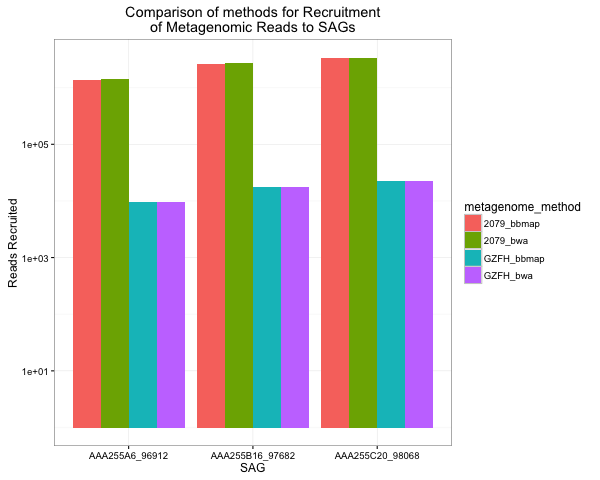

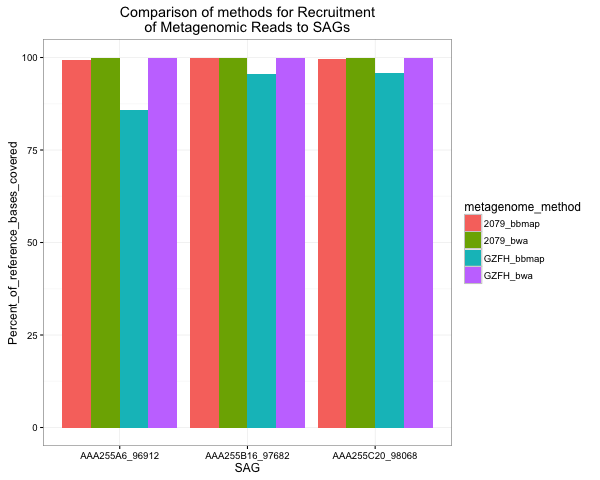

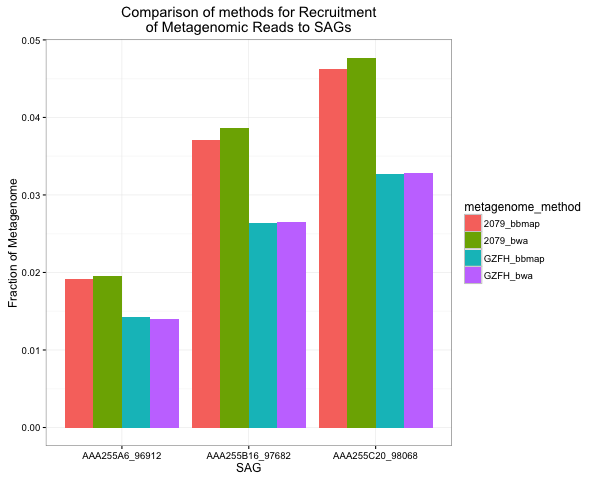

In [19]:
%%R -w 600
together %>% ggplot(aes(sag, as.numeric(as.character(unambiguous)))) + scale_y_log10() + theme_bw() -> p
p<- p+ geom_bar(aes(fill=vars), position="dodge", stat='identity') #+ theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill="metagenome_method", x="SAG", y="Reads Recruited", title="Comparison of methods for Recruitment\nof Metagenomic Reads to SAGs")
plot(p)

together %>% ggplot(aes(sag, as.numeric(as.character(Percent_of_reference_bases_covered)))) + theme_bw() -> p 
p<- p+ geom_bar(aes(fill=vars), position="dodge", stat='identity') #+ theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill="metagenome_method", x="SAG", y="Percent_of_reference_bases_covered", title="Comparison of methods for Recruitment\nof Metagenomic Reads to SAGs")
plot(p)

together %>% ggplot(aes(sag, as.numeric(as.character(frac_mg_reads)))) + theme_bw() -> p 
p<- p+ geom_bar(aes(fill=vars), position="dodge", stat='identity') #+ theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill="metagenome_method", x="SAG", y="Fraction of Metagenome", title="Comparison of methods for Recruitment\nof Metagenomic Reads to SAGs")
plot(p)

Let's scale the raw recruitment result up to include all sags, and just use bwa for the time being.  To do so: 

```
mg=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/illumina_joined_gt150.fastq.gz

outdir=/mnt/stepanauskas_nfs/julia/fragdev/illuminall/

log=iluminall_rcovlog.txt

parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg --reference {1} --outdir $outdir :::: allsakinawsags.txt

mg=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_gt150.fastq.gz

outdir=/mnt/stepanauskas_nfs/julia/fragdev/pyroall/

log=pyroall_rcovlog.txt
```